<a href="https://colab.research.google.com/github/nburiticanunez/Dimplomado_Ciencia_Datos/blob/main/Tareas/Tarea_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from math import sqrt
from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM

from tensorflow.keras.optimizers import Adam

from scipy import stats
from statsmodels.stats.diagnostic import normal_ad


In [2]:
data = "GOOG"
now = datetime.now()
data = yf.Ticker(data).history(start=(now-relativedelta(years=10)).strftime("%Y-%m-%d"),
                                            end=now.strftime("%Y-%m-%d"))[['Open', 'High', 'Low', 'Close', 'Volume']]




In [3]:
print(f'\n Forma de los datos: {data.shape}\n')
data


 Forma de los datos: (2518, 5)



,Open,High,Low,Close,Volume
Date,,,,,
2013-06-18 00:00:00-04:00,22.133289,22.440886,22.125816,22.431421,87000883
2013-06-19 00:00:00-04:00,22.450102,22.685966,22.353712,22.432917,117073180
2013-06-20 00:00:00-04:00,22.266291,22.440886,22.000288,22.035904,135385563
2013-06-21 00:00:00-04:00,22.125568,22.163923,21.745243,21.941010,159889066
2013-06-24 00:00:00-04:00,21.715605,21.826191,21.500660,21.663549,121128323
...,...,...,...,...,...
2023-06-12 00:00:00-04:00,123.394997,124.750000,122.349998,124.349998,22255700
2023-06-13 00:00:00-04:00,125.650002,125.860001,123.845001,124.430000,19287700
2023-06-14 00:00:00-04:00,123.800003,124.790001,122.160004,124.379997,24659600


In [4]:
google = data[['Close']]
google


,Close
Date,
2013-06-18 00:00:00-04:00,22.431421
2013-06-19 00:00:00-04:00,22.432917
2013-06-20 00:00:00-04:00,22.035904
2013-06-21 00:00:00-04:00,21.941010
2013-06-24 00:00:00-04:00,21.663549
...,...
2023-06-12 00:00:00-04:00,124.349998
2023-06-13 00:00:00-04:00,124.430000
2023-06-14 00:00:00-04:00,124.379997


In [5]:
# tamaño de pasos a futuro
future_target = 20

# tamaño secuencias de entrada
past_history = 55

def multipaso_data(dataset, target, start_index, end_index, history_size,
                      target_size,  single_step=False):
    ''' dataset: conjunto de datos para las secuencias de entrada
        target:  conjunto de datos para las secuencias de salida
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la ventana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
        single_step: Predecir solamente un valor futuro (=True),
                     o predecir todos los valores hasta target_size(=False)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

def create_and_train_model(X_train, y_train, X_test, y_test, units):
    input_shape = (X_train.shape[1], 1)

    inputs = Input(input_shape)
    x = Dropout(0.0, name= 'Dropout_01')(inputs)
    x = LSTM(units=units, name='LSTM_layer')(x)
    x = LSTM(units=units, return_sequences=True,name='LSTM_layer')(inputs)
    x = LSTM(units=units//2, name='LSTM_layer_2')(x)
    outputs = Dense(future_target)(x)

    # model
    model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
    model.compile(loss='mean_squared_error', optimizer=Adam(0.001))
    history = model.fit(
        X_train, y_train,
        epochs=40,
        batch_size=32,
        validation_split=0.2,
        verbose=1,
        shuffle=False
    )

    prediction = model.predict(X_test)
    pred = 0
    y_train_p = X_test[pred,:]
    y_test_p = y_test[pred,:]
    y_pred_p = prediction[pred,:]

    y_train_p = scaler.inverse_transform(y_train_p.reshape(-1, 1))
    y_test_p = scaler.inverse_transform(y_test_p.reshape(-1, 1))
    y_pred_p = scaler.inverse_transform(y_pred_p.reshape(-1, 1))

    return history, y_train_p, y_test_p, y_pred_p

def plot_residuals(residuals):
    sw_result = stats.shapiro(residuals)
    ad_result = normal_ad(np.array(residuals), axis=0)
    dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

    plt.figure(figsize=(15,7))
    res = stats.probplot(residuals, plot=plt)
    ax = plt.gca()
    ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
                bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
    ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
                bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
    ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
                bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

    plt.show()


def plot_confidence_intervals(residuals, y_train, y_test, y_pred):
    plt.figure(figsize=(20, 5))
    y_train = [arr[0] for arr in y_train.tolist()]
    y_test = [arr[0] for arr in y_test.tolist()]
    y_pred = [arr[0] for arr in y_pred.tolist()]

    RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
    band_size = 1.96*RMSFE

    fig, ax = plt.subplots(figsize=(15,7))
    ax.plot(list(range(len(y_train))), y_train, color='g', label='History')
    ax.plot(list(range(len(y_train), len(y_train) + len(y_test))), y_test, color='#fc7d0b', label='True')
    ax.scatter(list(range(len(y_train), len(y_train) + len(y_test))), y_pred)
    ax.fill_between(list(range(len(y_train), len(y_train) + len(y_test))), (y_test-band_size), (y_test+band_size), color='b', alpha=.1)
    ax.set_title("Predictions w/ 95% Confidence")
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Price')
    plt.show()



In [6]:
len_data = len(google)
len_train = int(len_data*0.8)
len_test = len_data- len_train

dataset = google.values
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = np.squeeze(np.array(scaler.fit_transform(dataset)),axis=1)

TRAIN_SPLIT = int(len_data*0.8)

X_train, y_train = multipaso_data(dataset, dataset, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target)
X_test, y_test = multipaso_data(dataset, dataset, TRAIN_SPLIT,
                                                 None, past_history,
                                                 future_target)

print(TRAIN_SPLIT)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


2014
(1959, 55)
(1959, 20)
(429, 55)
(429, 20)


In [7]:
history_google, y_train_google, y_test_google, y_pred_google = create_and_train_model(X_train, y_train, X_test, y_test, 50)



Epoch 1/40
49/49 [==============================] - 5s 48ms/step - loss: 0.0018 - val_loss: 0.0354
Epoch 2/40
49/49 [==============================] - 2s 42ms/step - loss: 0.0078 - val_loss: 0.0419
Epoch 3/40
49/49 [==============================] - 2s 33ms/step - loss: 0.0063 - val_loss: 0.0217
Epoch 4/40
49/49 [==============================] - 2s 33ms/step - loss: 0.0059 - val_loss: 0.0195
Epoch 5/40
49/49 [==============================] - 2s 33ms/step - loss: 0.0038 - val_loss: 0.0233
Epoch 6/40
49/49 [==============================] - 2s 33ms/step - loss: 0.0012 - val_loss: 0.0278
Epoch 7/40
49/49 [==============================] - 2s 34ms/step - loss: 3.9437e-04 - val_loss: 0.0233
Epoch 8/40
49/49 [==============================] - 2s 36ms/step - loss: 3.6522e-04 - val_loss: 0.0201
Epoch 9/40
49/49 [==============================] - 2s 41ms/step - loss: 3.6536e-04 - val_loss: 0.0174
Epoch 10/40
49/49 [==============================] - 2s 33ms/step - loss: 3.4361e-04 - val_loss: 

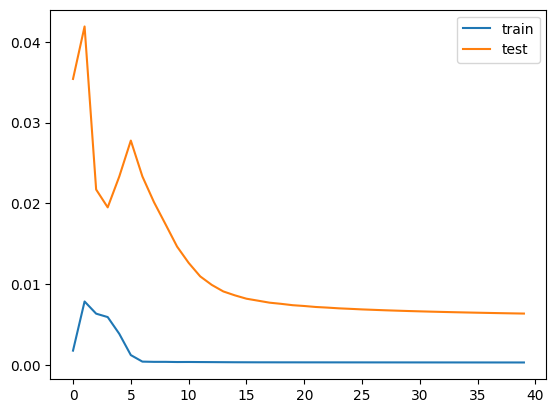

In [8]:
plt.plot(history_google.history['loss'], label='train')
plt.plot(history_google.history['val_loss'], label='test')
plt.legend();


<Figure size 2000x500 with 0 Axes>

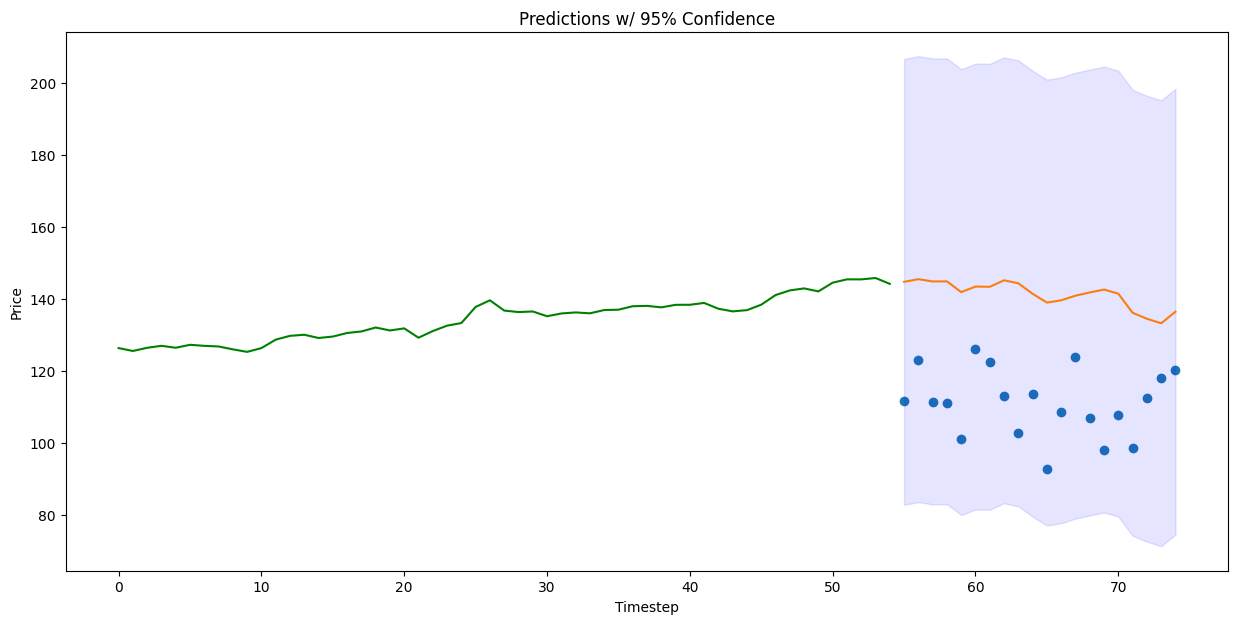

In [9]:
residuals_google = sorted([(x - y)[0] for x, y in zip(y_pred_google, y_test_google)])
plot_confidence_intervals(residuals_google, y_train_google, y_test_google, y_pred_google)
